# 1 代码训练（Project312）

## 1.1 为三种植被类型训练

## 🌳 T3C Vegetation VWC Machine Learning Pipeline (RFR)

### 📌 项目目的
使用哨兵卫星反演的 **VOD** 数据以及 **LAI / Hveg / PFT** 等植被特征，针对三类植被：
- Grass
- Shrub
- Tree

分别训练 **Random Forest Regression (RFR)** 模型，预测 **植被含水量 VWC**，并对比三个模型的预测精度（RMSE、R²）。

---

### 📁 数据来源
- 输入数据文件：`LFMC-gridMean-ML.xlsx`
- 主要字段：
  - 植被生物量：`AGB`
  - 实测含水量：`LFMCValue`
  - 植被指数：`LAI`, `Hveg`
  - 物候分区：`Grass_man`, `Grass_nat`, `Shrub_bd`, `Shrub_be`, `Shrub_nd`, `Shrub_ne`, `Tree_bd`, `Tree_be`, `Tree_nd`, `Tree_ne`
  - **VOD 多频多极化**：`VOD_Ku_Hpol_Asc`, `VOD_Ku_Vpol_Asc`, `VOD_X_Hpol_Asc`, `VOD_X_Vpol_Asc`, `VOD_C_Hpol_Asc`, `VOD_C_Vpol_Asc`

---

### 🔍 数据预处理与划分
1. 按照 `G_LFMC`, `S_LFMC`, `T_LFMC` 列对数据划分成：
   - Grass / Shrub / Tree
2. 每个子集计算目标变量：


In [2]:
import pandas as pd
import numpy as np
import os
import time
import joblib
import warnings
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from datetime import datetime

warnings.filterwarnings("ignore")

SEED = 42  # 统一随机种子
DATA_FILE_PATH = r"G:\Matlab\EX2025\AuxiliaryData\LFMC-gridMean-ML.xlsx"
BASE_SAVE_PATH = r"G:\data\VWC\VWCMap\T3C-VWC"

def load_and_prepare_base_data():
    """加载原始数据，并只进行到计算VWC_sample之前"""
    print("加载数据中...")

    required_columns = [
        'AGB', 'LFMCValue', 'SamplingDate', 'LAI', 'Hveg',
        'G_LFMC', 'S_LFMC', 'T_LFMC',
        'Grass_man', 'Grass_nat', 'Shrub_bd', 'Shrub_be', 'Shrub_nd', 'Shrub_ne',
        'Tree_bd', 'Tree_be', 'Tree_nd', 'Tree_ne',
        'VOD_Ku_Hpol_Asc', 'VOD_Ku_Vpol_Asc', 'VOD_X_Hpol_Asc', 'VOD_X_Vpol_Asc',
        'VOD_C_Hpol_Asc', 'VOD_C_Vpol_Asc'
    ]

    df = pd.read_excel(DATA_FILE_PATH, usecols=required_columns)

    if df.isnull().any().any():
        print("存在缺失值，正在剔除...")
        df = df.dropna()

    print(f"数据加载完毕，共 {len(df)} 行\n")
    return df


def split_plant_datasets(df):
    """拆分植物类型成Grass、Shrub、Tree"""
    print("按照PlantType分类数据...")

    grass = df[df["G_LFMC"] > 0].copy()
    shrub = df[df["S_LFMC"] > 0].copy()
    tree = df[df["T_LFMC"] > 0].copy()

    # 保留对应LFMC并新增类别字段
    grass = grass.drop(columns=["S_LFMC", "T_LFMC"])
    grass.rename(columns={"G_LFMC": "LFMC"}, inplace=True)
    grass["PlantType"] = "Grass"

    shrub = shrub.drop(columns=["G_LFMC", "T_LFMC"])
    shrub.rename(columns={"S_LFMC": "LFMC"}, inplace=True)
    shrub["PlantType"] = "Shrub"

    tree = tree.drop(columns=["G_LFMC", "S_LFMC"])
    tree.rename(columns={"T_LFMC": "LFMC"}, inplace=True)
    tree["PlantType"] = "Tree"

    # 计算 VWC_sample
    for d in [grass, shrub, tree]:
        d["VWC_sample"] = (d["AGB"] * d["LFMC"]) / 1000
        d["VWC_sample"] = d["VWC_sample"].clip(upper=30)

    print(f"Grass: {len(grass)}, Shrub: {len(shrub)}, Tree: {len(tree)}")
    return grass, shrub, tree


def train_and_save_model(df, plant_type):
    """给不同植物类型训练RFR并保存"""
    print(f"\n训练 {plant_type} 机器学习模型...")

    # 设置保存位置
    save_dir = os.path.join(BASE_SAVE_PATH, plant_type)
    os.makedirs(save_dir, exist_ok=True)

    # 定义特征
    vod_columns = ['VOD_Ku_Hpol_Asc','VOD_Ku_Vpol_Asc','VOD_X_Hpol_Asc',
                   'VOD_X_Vpol_Asc','VOD_C_Hpol_Asc','VOD_C_Vpol_Asc']
    pft_columns = ['Grass_man','Grass_nat','Shrub_bd','Shrub_be','Shrub_nd','Shrub_ne',
                   'Tree_bd','Tree_be','Tree_nd','Tree_ne']

    if plant_type == "Grass":
        feature_columns = vod_columns + ["LAI"] + pft_columns
    else:
        feature_columns = vod_columns + ["LAI","Hveg"] + pft_columns

    X = df[feature_columns].copy()
    y = df["VWC_sample"].copy()

    X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
        X, y, df.index, test_size=0.333, random_state=SEED, shuffle=True
    )

    model = RandomForestRegressor(n_estimators=100, random_state=SEED, n_jobs=-1)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    print(f"{plant_type} -> RMSE: {rmse:.4f}, R²: {r2:.4f}")

    # 保存模型
    model_path = os.path.join(save_dir, f"{plant_type}_RFR.pkl")
    joblib.dump(model, model_path)
    print(f"模型已保存: {model_path}")

    # 保存测试集简化数据
    df_test = df.loc[idx_test]
    df_test["y_pred"] = y_pred
    df_test["y_true"] = y_test.values
    df_test.to_csv(os.path.join(save_dir, f"{plant_type}_test_data.csv"), index=False)

    print(f"验证集记录保存: {os.path.join(save_dir, plant_type + '_test_data.csv')}")
    return rmse, r2

if __name__ == "__main__":
    df = load_and_prepare_base_data()
    grass, shrub, tree = split_plant_datasets(df)

    # 记录三个模型表现
    results = []

    for subset, name in [(grass, "Grass"), (shrub, "Shrub"), (tree, "Tree")]:
        rmse, r2 = train_and_save_model(subset, name)
        results.append([name, rmse, r2])

    summary = pd.DataFrame(results, columns=["PlantType", "RMSE", "R²"])
    print("\n=========================")
    print("  三个模型精度对比结果")
    print("=========================")
    print(summary.to_string(index=False))
    print("=========================\n")

    print("✔ 全部模型训练完成！")


加载数据中...
存在缺失值，正在剔除...
数据加载完毕，共 16099 行

按照PlantType分类数据...
Grass: 1736, Shrub: 4595, Tree: 14044

训练 Grass 机器学习模型...
Grass -> RMSE: 3.4084, R²: 0.7807
模型已保存: G:\data\VWC\VWCMap\T3C-VWC\Grass\Grass_RFR.pkl
验证集记录保存: G:\data\VWC\VWCMap\T3C-VWC\Grass\Grass_test_data.csv

训练 Shrub 机器学习模型...
Shrub -> RMSE: 2.2290, R²: 0.8585
模型已保存: G:\data\VWC\VWCMap\T3C-VWC\Shrub\Shrub_RFR.pkl
验证集记录保存: G:\data\VWC\VWCMap\T3C-VWC\Shrub\Shrub_test_data.csv

训练 Tree 机器学习模型...
Tree -> RMSE: 1.6012, R²: 0.9032
模型已保存: G:\data\VWC\VWCMap\T3C-VWC\Tree\Tree_RFR.pkl
验证集记录保存: G:\data\VWC\VWCMap\T3C-VWC\Tree\Tree_test_data.csv

  三个模型精度对比结果
PlantType     RMSE       R²
    Grass 3.408366 0.780668
    Shrub 2.229046 0.858518
     Tree 1.601215 0.903156

✔ 全部模型训练完成！


Grass(原始数据共12635条)+Forb(非禾本草本植物)+Graminoid(类禾本科植物)+Liana(藤本植物)+(苔藓地衣+寄生物，还是不要了吧)+Sedge(莎草),原始数据共14289条（也很少）| Shrub(原始数据共110848条)+Large shrub+Shrub/Small tree+Subshrub(亚灌木),原始数据共111988条 | Tree(原始数据共166936条)

## 1.2 生产VWC逐日数据集

In [1]:
# 先生成三个模型2015年的结果
# 用于同时调用 VWC + Hveg (TH) 和 VWC 无 Hveg (NoTH) 版本的脚本

import sys
import os
from datetime import datetime

# ============================== 路径设置 & 模块导入 ==============================

# 假设您的项目结构包含 'function' 目录
sys.path.append("./function")

try:
    # 导入 VWC + Hveg (TH) 的并行版本
    from vwc_generator import run_vwc_generation as run_vwc_hveg 
    
    # 导入 VWC 无 Hveg (NoTH) 的同步版本
    from vwc_generator_noth import run_vwc_generation as run_vwc_no_hveg 
    
except ImportError as e:
    print(f"导入失败。请检查文件是否存在且路径设置正确。错误信息: {e}")
    # 终止执行
    sys.exit(1)

# ============================== 基础配置 ==============================

# 时间配置 
START_DATE_STR = '2002-06-01'
END_DATE_STR = '2020-12-31' 

# 运行参数
OVERWRITE_EXISTING = True
MAX_WORKERS = 4 # 仅用于 run_vwc_hveg (并行版本)

# 数据基础路径（请根据您的实际环境修改）
VOD_PATH = r"G:\data\VOD\mat\kuxcVOD\ASC"
LAI_PATH = r"G:\data\GLASS LAI\mat\0.1Deg\Dataset"
PFT_PATH = r"G:\data\ESACCI PFT\Resample\Data"

# ============================== 任务 1: VWC + Hveg (Tree) 配置 ==============================
OUTPUT_Tree = r"G:\data\VWC\VWCMap\T3C-VWC\Daily\Tree"
MODEL_Tree = r'G:\data\VWC\VWCMap\T3C-VWC\Tree\Tree_RFR.pkl' 

PATH_CONFIG_TREE = {
    'vod_base_path': VOD_PATH,
    'lai_base_path': LAI_PATH,
    'pft_base_path': PFT_PATH,
    'hveg_path': r'G:\data\CanopyHeight\CH.mat', 
    'output_path': OUTPUT_Tree,
    'model_path': MODEL_Tree
}
os.makedirs(OUTPUT_Tree, exist_ok=True)


# ============================== 任务 2: VWC + Hveg (Shrub) 配置 ==============================
OUTPUT_Shrub = r"G:\data\VWC\VWCMap\T3C-VWC\Daily\Shrub"
MODEL_Shrub = r'G:\data\VWC\VWCMap\T3C-VWC\Shrub\Shrub_RFR.pkl' 

PATH_CONFIG_SHRUB = {
    'vod_base_path': VOD_PATH,
    'lai_base_path': LAI_PATH,
    'pft_base_path': PFT_PATH,
    'hveg_path': r'G:\data\CanopyHeight\CH.mat', 
    'output_path': OUTPUT_Shrub,
    'model_path': MODEL_Shrub
}
os.makedirs(OUTPUT_Shrub, exist_ok=True)


# ============================== 任务 3: VWC 无 Hveg (Grass) 配置 ==============================
OUTPUT_Grass = r"G:\data\VWC\VWCMap\T3C-VWC\Daily\Grass"
MODEL_Grass = r'G:\data\VWC\VWCMap\T3C-VWC\Grass\Grass_RFR.pkl' 

PATH_CONFIG_GRASS = { # 重命名为 PATH_CONFIG_GRASS
    'vod_base_path': VOD_PATH,
    'lai_base_path': LAI_PATH,
    'pft_base_path': PFT_PATH,
    # 'hveg_path' 必须移除
    'output_path': OUTPUT_Grass,
    'model_path': MODEL_Grass
}
os.makedirs(OUTPUT_Grass, exist_ok=True)

# ============================== 执行主函数 ==============================

# ============================== 执行主函数 (修改后) ==============================

def main():
    
    # ------------------
    # 任务 1: VWC + Hveg (Tree) - 并行
    # ------------------
    print("\n\n#####################################################")
    print(f">>> 任务 1/3: VWC + Hveg (Tree) 模型 | 输出: {OUTPUT_Tree}")
    print("#####################################################")
    
    if not os.path.exists(PATH_CONFIG_TREE['model_path']):
        print(f"⚠️ 警告：Tree 模型文件未找到: {PATH_CONFIG_TREE['model_path']}，跳过此任务。")
    else:
        completed_tree, failed_tree = run_vwc_hveg(
            start_date_str=START_DATE_STR,
            end_date_str=END_DATE_STR,
            overwrite=OVERWRITE_EXISTING,
            max_workers=MAX_WORKERS,
            **PATH_CONFIG_TREE # 使用 TREE 配置
        )
        print(f"\n[总结 1/3] VWC + Hveg (Tree) 结果: 成功 {completed_tree} 天, 失败 {failed_tree} 天")


    # ------------------
    # 任务 2: VWC + Hveg (Shrub) - 并行
    # ------------------
    print("\n\n#####################################################")
    print(f">>> 任务 2/3: VWC + Hveg (Shrub) 模型 | 输出: {OUTPUT_Shrub}")
    print("#####################################################")

    if not os.path.exists(PATH_CONFIG_SHRUB['model_path']):
        print(f"⚠️ 警告：Shrub 模型文件未找到: {PATH_CONFIG_SHRUB['model_path']}，跳过此任务。")
    else:
        completed_shrub, failed_shrub = run_vwc_hveg(
            start_date_str=START_DATE_STR,
            end_date_str=END_DATE_STR,
            overwrite=OVERWRITE_EXISTING,
            max_workers=MAX_WORKERS,
            **PATH_CONFIG_SHRUB # 使用 SHRUB 配置
        )
        print(f"\n[总结 2/3] VWC + Hveg (Shrub) 结果: 成功 {completed_shrub} 天, 失败 {failed_shrub} 天")


    # ------------------
    # 任务 3: VWC 无 Hveg (Grass) - 同步
    # ------------------
    print("\n\n#####################################################")
    print(f">>> 任务 3/3: VWC 无 Hveg (Grass) 模型 | 输出: {OUTPUT_Grass}")
    print("#####################################################")

    if not os.path.exists(PATH_CONFIG_GRASS['model_path']):
        print(f"⚠️ 警告：Grass 模型文件未找到: {PATH_CONFIG_GRASS['model_path']}，跳过此任务。")
    else:
        # run_vwc_no_hveg 是同步版本，无需 max_workers 参数
        completed_grass, failed_grass = run_vwc_no_hveg(
            start_date_str=START_DATE_STR,
            end_date_str=END_DATE_STR,
            overwrite=OVERWRITE_EXISTING,
            **PATH_CONFIG_GRASS # 使用 GRASS 配置
        )
        print(f"\n[总结 3/3] VWC 无 Hveg (Grass) 结果: 成功 {completed_grass} 天, 失败 {failed_grass} 天")


if __name__ == "__main__":
    main()

2025-11-29 17:55:25,506 - INFO - 初始化 VWCGenerator...




#####################################################
>>> 任务 1/3: VWC + Hveg (Tree) 模型 | 输出: G:\data\VWC\VWCMap\T3C-VWC\Daily\Tree
#####################################################


2025-11-29 17:55:26,883 - INFO - 成功加载模型: G:\data\VWC\VWCMap\T3C-VWC\Tree\Tree_RFR.pkl
2025-11-29 17:55:26,884 - INFO - 模型期望的特征顺序: VOD_Ku_Hpol_Asc, VOD_Ku_Vpol_Asc, VOD_X_Hpol_Asc, VOD_X_Vpol_Asc, VOD_C_Hpol_Asc, VOD_C_Vpol_Asc, LAI, Hveg, Grass_man, Grass_nat, Shrub_bd, Shrub_be, Shrub_nd, Shrub_ne, Tree_bd, Tree_be, Tree_nd, Tree_ne
2025-11-29 17:55:26,884 - INFO - 加载Hveg数据: G:\data\CanopyHeight\CH.mat
2025-11-29 17:55:27,133 - INFO - 成功加载Hveg数据: Hveg
2025-11-29 17:55:27,134 - INFO - Hveg数据加载完成: (1800, 3600)
2025-11-29 17:55:27,138 - INFO - 陆地掩膜创建完成: 有效点=5040000
2025-11-29 17:55:27,140 - INFO - 开始并行处理6789天数据，最大线程数: 4
2025-11-29 17:55:27,142 - INFO - 处理日期: 2002-06-01
2025-11-29 17:55:27,144 - INFO - 处理日期: 2002-06-02
2025-11-29 17:55:27,183 - INFO - 处理日期: 2002-06-03


开始处理: 2002-06-01 到 2020-12-31


生成VWC影像:   0%|          | 0/6789 [00:00<?, ?it/s]2025-11-29 17:55:27,362 - INFO - 处理日期: 2002-06-04
2025-11-29 17:55:32,634 - INFO - 有效数据点数量: 222189
2025-11-29 17:55:32,894 - INFO - 有效数据点数量: 950090
2025-11-29 17:55:32,952 - INFO - 有效数据点数量: 907268
2025-11-29 17:55:33,192 - INFO - 有效数据点数量: 847483
2025-11-29 17:55:34,065 - INFO - 预测值统计: min=0.0202, max=26.3518, mean=5.0351
2025-11-29 17:55:34,563 - INFO - 成功创建GeoTIFF: G:\data\VWC\VWCMap\T3C-VWC\Daily\Tree\VWC-20020601.tif
生成VWC影像:   0%|          | 1/6789 [00:07<13:51:34,  7.35s/it]2025-11-29 17:55:34,634 - INFO - 处理日期: 2002-06-05




2025-11-29 17:55:36,002 - INFO - 有效数据点数量: 948068


2025-11-29 17:55:36,835 - INFO - 预测值统计: min=0.0214, max=26.9213, mean=3.8318


2025-11-29 17:55:37,033 - INFO - 预测值统计: min=0.0156, max=27.0036, mean=3.7292
2025-11-29 17:55:37,097 - INFO - 成功创建GeoTIFF: G:\data\VWC\VWCMap\T3C-VWC\Daily\Tree\VWC-20020602.tif
生成VWC影像:   0%|          | 2/6789 [00:09<8:32:32,  4.53s/it] 2025-11-29 17:55:37,198 - INFO - 处理日期: 2002-0

VWC影像生成完成: 成功 6449 天, 失败 340 天

[总结 1/3] VWC + Hveg (Tree) 结果: 成功 6449 天, 失败 340 天


#####################################################
>>> 任务 2/3: VWC + Hveg (Shrub) 模型 | 输出: G:\data\VWC\VWCMap\T3C-VWC\Daily\Shrub
#####################################################


2025-11-29 20:13:39,249 - INFO - 成功加载模型: G:\data\VWC\VWCMap\T3C-VWC\Shrub\Shrub_RFR.pkl
2025-11-29 20:13:39,249 - INFO - 模型期望的特征顺序: VOD_Ku_Hpol_Asc, VOD_Ku_Vpol_Asc, VOD_X_Hpol_Asc, VOD_X_Vpol_Asc, VOD_C_Hpol_Asc, VOD_C_Vpol_Asc, LAI, Hveg, Grass_man, Grass_nat, Shrub_bd, Shrub_be, Shrub_nd, Shrub_ne, Tree_bd, Tree_be, Tree_nd, Tree_ne
2025-11-29 20:13:39,251 - INFO - 加载Hveg数据: G:\data\CanopyHeight\CH.mat
2025-11-29 20:13:47,868 - INFO - 成功加载Hveg数据: Hveg
2025-11-29 20:13:47,869 - INFO - Hveg数据加载完成: (1800, 3600)
2025-11-29 20:13:47,874 - INFO - 陆地掩膜创建完成: 有效点=5040000
2025-11-29 20:13:47,877 - INFO - 开始并行处理6789天数据，最大线程数: 4


开始处理: 2002-06-01 到 2020-12-31


生成VWC影像:   0%|          | 0/6789 [00:00<?, ?it/s]2025-11-29 20:13:48,081 - INFO - 处理日期: 2002-06-01
2025-11-29 20:13:48,089 - INFO - 处理日期: 2002-06-02
2025-11-29 20:13:48,089 - INFO - 处理日期: 2002-06-03
2025-11-29 20:13:48,089 - INFO - 处理日期: 2002-06-04
2025-11-29 20:15:03,562 - INFO - 有效数据点数量: 222189
2025-11-29 20:15:04,191 - INFO - 预测值统计: min=0.0011, max=25.5398, mean=5.7313
2025-11-29 20:15:04,274 - INFO - 有效数据点数量: 907268
2025-11-29 20:15:04,307 - INFO - 成功创建GeoTIFF: G:\data\VWC\VWCMap\T3C-VWC\Daily\Shrub\VWC-20020601.tif
生成VWC影像:   0%|          | 1/6789 [01:16<144:07:38, 76.44s/it]2025-11-29 20:15:04,456 - INFO - 处理日期: 2002-06-05
2025-11-29 20:15:04,595 - INFO - 有效数据点数量: 847483
2025-11-29 20:15:05,259 - INFO - 有效数据点数量: 950090
2025-11-29 20:15:05,647 - INFO - 有效数据点数量: 948068

2025-11-29 20:15:06,592 - INFO - 预测值统计: min=0.0008, max=27.4484, mean=4.4216
2025-11-29 20:15:06,804 - INFO - 成功创建GeoTIFF: G:\data\VWC\VWCMap\T3C-VWC\Daily\Shrub\VWC-20020604.tif
生成VWC影像:   0%|          | 2/6789 [01

VWC影像生成完成: 成功 6449 天, 失败 340 天

[总结 2/3] VWC + Hveg (Shrub) 结果: 成功 6449 天, 失败 340 天


#####################################################
>>> 任务 3/3: VWC 无 Hveg (Grass) 模型 | 输出: G:\data\VWC\VWCMap\T3C-VWC\Daily\Grass
#####################################################


2025-11-29 22:26:13,630 - INFO - 成功加载模型: G:\data\VWC\VWCMap\T3C-VWC\Grass\Grass_RFR.pkl
2025-11-29 22:26:13,631 - INFO - 模型期望的特征顺序: VOD_Ku_Hpol_Asc, VOD_Ku_Vpol_Asc, VOD_X_Hpol_Asc, VOD_X_Vpol_Asc, VOD_C_Hpol_Asc, VOD_C_Vpol_Asc, LAI, Grass_man, Grass_nat, Shrub_bd, Shrub_be, Shrub_nd, Shrub_ne, Tree_bd, Tree_be, Tree_nd, Tree_ne
2025-11-29 22:26:13,637 - INFO - 陆地掩膜创建完成: 有效点=5040000
2025-11-29 22:26:13,643 - INFO - 开始同步处理6789天数据


开始处理: 2002-06-01 到 2020-12-31


生成VWC影像:   0%|          | 0/6789 [00:00<?, ?it/s]2025-11-29 22:26:13,646 - INFO - 处理日期: 2002-06-01
2025-11-29 22:26:15,195 - INFO - 有效数据点数量: 222189
2025-11-29 22:26:15,686 - INFO - 预测值统计: min=0.0405, max=20.8905, mean=4.8291
2025-11-29 22:26:15,793 - INFO - 成功创建GeoTIFF: G:\data\VWC\VWCMap\T3C-VWC\Daily\Grass\VWC-20020601.tif
生成VWC影像:   0%|          | 1/6789 [00:02<4:05:00,  2.17s/it]2025-11-29 22:26:15,812 - INFO - 处理日期: 2002-06-02
2025-11-29 22:26:16,516 - INFO - 有效数据点数量: 950090
2025-11-29 22:26:17,906 - INFO - 预测值统计: min=0.0163, max=25.2430, mean=4.0734
2025-11-29 22:26:18,027 - INFO - 成功创建GeoTIFF: G:\data\VWC\VWCMap\T3C-VWC\Daily\Grass\VWC-20020602.tif
生成VWC影像:   0%|          | 2/6789 [00:04<4:09:58,  2.21s/it]2025-11-29 22:26:18,053 - INFO - 处理日期: 2002-06-03
2025-11-29 22:26:18,694 - INFO - 有效数据点数量: 847483
2025-11-29 22:26:19,952 - INFO - 预测值统计: min=0.0212, max=24.4087, mean=4.0680
2025-11-29 22:26:20,068 - INFO - 成功创建GeoTIFF: G:\data\VWC\VWCMap\T3C-VWC\Daily\Grass\VWC-20020603.tif

VWC影像生成完成: 成功 6449 天, 失败 340 天

[总结 3/3] VWC 无 Hveg (Grass) 结果: 成功 6449 天, 失败 340 天


In [2]:
import os
import sys
import numpy as np
import h5py
import rasterio
from datetime import datetime, timedelta
# 引入 tqdm 库
from tqdm import tqdm 

# --- 依赖库：h5py, rasterio, numpy, tqdm ---
# pip install h5py rasterio numpy tqdm

# ============================== 配置区域 (已更新时间范围) ==============================

# 时间配置
START_DATE_STR = '2002-06-01' # <-- 新起始时间
END_DATE_STR = '2020-12-31' # <-- 新结束时间

# 输入路径配置
BASE_INPUT_DIR = r"G:\data\VWC\VWCMap\T3C-VWC\Daily"
INPUT_DIRS = {
    'Grass': os.path.join(BASE_INPUT_DIR, "Grass"),
    'Shrub': os.path.join(BASE_INPUT_DIR, "Shrub"),
    'Tree': os.path.join(BASE_INPUT_DIR, "Tree")
}
# 输出路径
OUTPUT_MERGED_DIR = BASE_INPUT_DIR

# PFT 辅助文件配置 (改为基目录)
PFT_PATH = r"G:\data\ESACCI PFT\Resample\Data" # <-- 仅保留 PFT 文件的目录
NODATA_VALUE = -9999.0

# VWC 影像的预期形状
EXPECTED_VWC_SHAPE = (1800, 3600) 

# ============================== 函数定义：PFT 处理 (不变) ==============================

def load_pft_weights(pft_mat_file):
    """
    读取 PFT .mat 文件，计算 Tree, Shrub, Grass 的权重，并转置以匹配 VWC 影像。
    """
    # 打印语句调整，减少循环中的输出
    # print(f"加载 PFT 文件用于计算权重: {pft_mat_file}") 
    
    if not os.path.exists(pft_mat_file):
        raise FileNotFoundError(f"PFT 文件未找到: {pft_mat_file}")
        
    try:
        with h5py.File(pft_mat_file, 'r') as f:
            pft_vars = {name: f[name][:] for name in [
                'grassman', 'grassnat', 
                'shrubnd', 'shrubne', 'shrubbd', 'shrubbe', 
                'treend', 'treene', 'treebd', 'treebe'
            ]}
            
            # 检查并处理转置 (基于之前的调试结果)
            if pft_vars['grassman'].shape == EXPECTED_VWC_SHAPE[::-1]:
                # print(f"PFT 原始形状 {pft_vars['grassman'].shape}，正在转置...")
                for key in pft_vars:
                    pft_vars[key] = pft_vars[key].T
            elif pft_vars['grassman'].shape != EXPECTED_VWC_SHAPE:
                 raise ValueError(f"PFT 形状 {pft_vars['grassman'].shape} 与预期 VWC 形状 {EXPECTED_VWC_SHAPE} 不匹配！")
            
            # print(f"PFT 权重数组形状: {pft_vars['grassman'].shape}")

            # 计算合成权重（Fractional Cover）
            weights = {}
            weights['Grass'] = (pft_vars['grassman'] + pft_vars['grassnat']) / 100.0
            weights['Shrub'] = (pft_vars['shrubnd'] + pft_vars['shrubne'] + 
                                pft_vars['shrubbd'] + pft_vars['shrubbe']) / 100.0
            weights['Tree'] = (pft_vars['treend'] + pft_vars['treene'] + 
                               pft_vars['treebd'] + pft_vars['treebe']) / 100.0
            
            for key in weights:
                weights[key] = np.clip(weights[key], 0.0, 1.0)
                
            return weights
            
    except Exception as e:
        print(f"读取或处理 PFT 文件时发生错误: {e}")
        sys.exit(1)

# ============================== 函数定义：VWC 合成 (已修改) ==============================

def merge_t3c_vwc(start_date_str, end_date_str, input_dirs, output_dir, pft_path):
    """
    根据 PFT 权重，对 T3C-VWC 产品进行加权求和合成，并显示进度条。
    """
    print("\n--- 启动 T3C-VWC 产品加权合成 ---")
    
    start_date = datetime.strptime(start_date_str, '%Y-%m-%d')
    end_date = datetime.strptime(end_date_str, '%Y-%m-%d')
    
    # 计算总处理天数用于进度条
    total_days = (end_date - start_date).days + 1
    
    # 动态 PFT 加载所需变量
    current_year = None
    pft_weights = None
    
    current_date = start_date
    processed_count = 0
    
    # 使用 tqdm 创建进度条
    with tqdm(total=total_days, desc="VWC 合成进度") as pbar:
        while current_date <= end_date:
            
            # 1. 动态加载 PFT 权重
            date_year = current_date.year
            if date_year != current_year:
                pbar.write(f"\n>>>> 切换到年份 {date_year}，重新加载 PFT 权重...")
                pft_mat_file = os.path.join(pft_path, f'{date_year}.mat') 
                
                try:
                    pft_weights = load_pft_weights(pft_mat_file)
                    current_year = date_year 
                    pbar.write(f"✅ PFT 权重加载成功。")
                except FileNotFoundError:
                    pbar.write(f"⚠️ 警告：年份 {date_year} 的 PFT 文件缺失 ({pft_mat_file})。跳过该年的剩余日期。")
                    # 跳到下一年第一天
                    current_date = datetime(date_year + 1, 1, 1)
                    continue # 进入下一个 while 循环
                except Exception as e:
                    pbar.write(f"❌ 严重错误：加载 PFT 权重失败。程序终止。错误: {e}")
                    sys.exit(1)

            # 2. 文件路径
            date_str = current_date.strftime('%Y%m%d')
            filename = f"VWC-{date_str}.tif" 
            
            path_tree = os.path.join(input_dirs['Tree'], filename)
            path_shrub = os.path.join(input_dirs['Shrub'], filename)
            path_grass = os.path.join(input_dirs['Grass'], filename)
            path_out = os.path.join(output_dir, filename)

            # 3. 检查输入文件是否存在
            if not (os.path.exists(path_tree) and os.path.exists(path_shrub) and os.path.exists(path_grass)):
                current_date += timedelta(days=1)
                pbar.update(1) # 即使跳过也要更新进度条
                continue
                
            try:
                # ... (VWC 数据读取和加权合成的逻辑不变) ...
                
                # 读取所有 VWC 数据和元数据
                vwc_data = {}
                profile = None
                for pft_type, path in zip(['Tree', 'Shrub', 'Grass'], [path_tree, path_shrub, path_grass]):
                    with rasterio.open(path) as src:
                        data = src.read(1).astype(np.float32)
                        data[data == NODATA_VALUE] = np.nan
                        vwc_data[pft_type] = data
                        
                        if profile is None:
                            profile = src.profile 

                # 执行加权合成（逐像元处理 NaN）
                sum_vwc = np.zeros_like(vwc_data['Tree'], dtype=np.float32)
                
                if vwc_data['Tree'].shape != pft_weights['Tree'].shape:
                     raise ValueError("VWC 和 PFT 权重形状不匹配!")

                for pft_type in ['Tree', 'Shrub', 'Grass']:
                    data = vwc_data[pft_type]
                    weight = pft_weights[pft_type]
                    
                    valid_mask = ~np.isnan(data)
                    sum_vwc[valid_mask] += data[valid_mask] * weight[valid_mask]

                final_vwc = sum_vwc
                
                # 处理完全 NaN 的像元
                all_nan_mask = np.logical_and.reduce((np.isnan(vwc_data['Tree']), 
                                                      np.isnan(vwc_data['Shrub']), 
                                                      np.isnan(vwc_data['Grass'])))
                final_vwc[all_nan_mask] = np.nan
                
                # 替换 NaN 并写入文件
                final_vwc[np.isnan(final_vwc)] = NODATA_VALUE
                
                profile.update(dtype=final_vwc.dtype, nodata=NODATA_VALUE) 
                
                with rasterio.open(path_out, 'w', **profile) as dst:
                    dst.write(final_vwc, 1)

                processed_count += 1
                
            except Exception as e:
                pbar.write(f"❌ 处理文件 {filename} 时失败: {e}")
                
            current_date += timedelta(days=1)
            pbar.update(1) # 每日更新进度条
            
    pbar.write(f"\n--- T3C-VWC 产品加权合成完成。总计处理文件数: {processed_count} ---")


# ============================== 主程序运行 (已修改) ==============================

if __name__ == "__main__":
    
    print("\n\n#####################################################")
    print(">>> 独立任务: T3C-VWC 产品加权合成")
    print("#####################################################")
    
    try:
        # 1. 确保输出目录存在
        os.makedirs(OUTPUT_MERGED_DIR, exist_ok=True)
        
        # 2. 执行合成 (传入 PFT_PATH 基目录)
        merge_t3c_vwc(
            START_DATE_STR, END_DATE_STR, 
            INPUT_DIRS, OUTPUT_MERGED_DIR, 
            PFT_PATH # <-- 传入 PFT 文件的基目录
        )
    except Exception as e:
        print(f"\n❗ 合成过程中发生未知错误: {e}")



#####################################################
>>> 独立任务: T3C-VWC 产品加权合成
#####################################################

--- 启动 T3C-VWC 产品加权合成 ---


VWC 合成进度:   0%|          | 0/6789 [00:00<?, ?it/s]    


>>>> 切换到年份 2002，重新加载 PFT 权重...


VWC 合成进度:   0%|          | 0/6789 [00:01<?, ?it/s]    

✅ PFT 权重加载成功。


VWC 合成进度:   3%|▎         | 214/6789 [02:35<1:06:26,  1.65it/s]    


>>>> 切换到年份 2003，重新加载 PFT 权重...


VWC 合成进度:   3%|▎         | 214/6789 [02:36<1:06:26,  1.65it/s]    

✅ PFT 权重加载成功。


VWC 合成进度:   9%|▊         | 579/6789 [07:13<1:03:07,  1.64it/s]    


>>>> 切换到年份 2004，重新加载 PFT 权重...


VWC 合成进度:   9%|▊         | 579/6789 [07:14<1:03:07,  1.64it/s]    

✅ PFT 权重加载成功。


VWC 合成进度:  14%|█▍        | 945/6789 [11:58<1:20:18,  1.21it/s]    


>>>> 切换到年份 2005，重新加载 PFT 权重...


VWC 合成进度:  14%|█▍        | 945/6789 [11:59<1:20:18,  1.21it/s]    

✅ PFT 权重加载成功。


VWC 合成进度:  19%|█▉        | 1310/6789 [16:53<59:35,  1.53it/s]    


>>>> 切换到年份 2006，重新加载 PFT 权重...


VWC 合成进度:  19%|█▉        | 1310/6789 [16:54<59:35,  1.53it/s]    

✅ PFT 权重加载成功。


VWC 合成进度:  25%|██▍       | 1675/6789 [21:36<53:27,  1.59it/s]    


>>>> 切换到年份 2007，重新加载 PFT 权重...


VWC 合成进度:  25%|██▍       | 1675/6789 [21:37<53:27,  1.59it/s]    

✅ PFT 权重加载成功。


VWC 合成进度:  30%|███       | 2040/6789 [26:14<53:04,  1.49it/s]    


>>>> 切换到年份 2008，重新加载 PFT 权重...


VWC 合成进度:  30%|███       | 2040/6789 [26:16<53:04,  1.49it/s]    

✅ PFT 权重加载成功。


VWC 合成进度:  35%|███▌      | 2406/6789 [30:57<44:06,  1.66it/s]    


>>>> 切换到年份 2009，重新加载 PFT 权重...


VWC 合成进度:  35%|███▌      | 2406/6789 [30:58<44:06,  1.66it/s]    

✅ PFT 权重加载成功。


VWC 合成进度:  41%|████      | 2771/6789 [35:45<45:48,  1.46it/s]    


>>>> 切换到年份 2010，重新加载 PFT 权重...


VWC 合成进度:  41%|████      | 2771/6789 [35:46<45:48,  1.46it/s]    

✅ PFT 权重加载成功。


VWC 合成进度:  46%|████▌     | 3136/6789 [40:25<37:11,  1.64it/s]    


>>>> 切换到年份 2011，重新加载 PFT 权重...


VWC 合成进度:  46%|████▌     | 3136/6789 [40:26<37:11,  1.64it/s]    

✅ PFT 权重加载成功。


VWC 合成进度:  52%|█████▏    | 3501/6789 [44:00<01:23, 39.43it/s]    


>>>> 切换到年份 2012，重新加载 PFT 权重...


VWC 合成进度:  53%|█████▎    | 3593/6789 [44:02<00:45, 70.80it/s]    

✅ PFT 权重加载成功。


VWC 合成进度:  57%|█████▋    | 3867/6789 [46:22<31:26,  1.55it/s]    


>>>> 切换到年份 2013，重新加载 PFT 权重...


VWC 合成进度:  57%|█████▋    | 3867/6789 [46:23<31:26,  1.55it/s]    

✅ PFT 权重加载成功。


VWC 合成进度:  62%|██████▏   | 4232/6789 [50:57<27:49,  1.53it/s]    


>>>> 切换到年份 2014，重新加载 PFT 权重...


VWC 合成进度:  62%|██████▏   | 4232/6789 [50:58<27:49,  1.53it/s]    

✅ PFT 权重加载成功。


VWC 合成进度:  68%|██████▊   | 4597/6789 [55:34<23:12,  1.57it/s]    


>>>> 切换到年份 2015，重新加载 PFT 权重...


VWC 合成进度:  68%|██████▊   | 4597/6789 [55:35<23:12,  1.57it/s]    

✅ PFT 权重加载成功。


VWC 合成进度:  73%|███████▎  | 4962/6789 [1:00:28<20:45,  1.47it/s]    


>>>> 切换到年份 2016，重新加载 PFT 权重...


VWC 合成进度:  73%|███████▎  | 4962/6789 [1:00:29<20:45,  1.47it/s]    

✅ PFT 权重加载成功。


VWC 合成进度:  78%|███████▊  | 5328/6789 [1:04:56<14:57,  1.63it/s]    


>>>> 切换到年份 2017，重新加载 PFT 权重...


VWC 合成进度:  78%|███████▊  | 5328/6789 [1:04:57<14:57,  1.63it/s]    

✅ PFT 权重加载成功。


VWC 合成进度:  84%|████████▍ | 5693/6789 [1:09:25<11:36,  1.57it/s]    


>>>> 切换到年份 2018，重新加载 PFT 权重...


VWC 合成进度:  84%|████████▍ | 5693/6789 [1:09:26<11:36,  1.57it/s]    

✅ PFT 权重加载成功。


VWC 合成进度:  89%|████████▉ | 6058/6789 [1:13:53<07:39,  1.59it/s]    


>>>> 切换到年份 2019，重新加载 PFT 权重...


VWC 合成进度:  89%|████████▉ | 6058/6789 [1:13:54<07:39,  1.59it/s]    

✅ PFT 权重加载成功。


VWC 合成进度:  95%|█████████▍| 6423/6789 [1:18:15<03:52,  1.57it/s]    


>>>> 切换到年份 2020，重新加载 PFT 权重...


VWC 合成进度:  95%|█████████▍| 6423/6789 [1:18:16<03:52,  1.57it/s]    

✅ PFT 权重加载成功。


VWC 合成进度: 100%|██████████| 6789/6789 [1:22:50<00:00,  1.37it/s]


--- T3C-VWC 产品加权合成完成。总计处理文件数: 6448 ---


## 1.3 月数据合成

In [4]:
# 月度数据合成（适配单波段VWC图像）
import os
import numpy as np
from osgeo import gdal, osr
import datetime
import re
import logging
from tqdm import tqdm

# ============================== 配置日志 ==============================
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.StreamHandler(),
        logging.FileHandler('vwc_monthly_composite.log')
    ]
)
logger = logging.getLogger()

# ============================== 配置参数 ==============================
INPUT_DIR = r'G:\data\VWC\VWCMap\T3C-VWC\Daily'  # 每日VWC数据目录
OUTPUT_DIR = r'G:\data\VWC\VWCMap\T3C-VWC\Monthly'  # 月度合成输出目录
START_YEAR = 2015
END_YEAR = 2015
NODATA_VALUE = -9999.0
OVERWRITE_EXISTING = True  # 是否覆盖已存在的月度合成文件

# 确保输出目录存在
os.makedirs(OUTPUT_DIR, exist_ok=True)

# ============================== 辅助函数 ==============================
def get_daily_files_for_month(year, month):
    """获取指定年月的所有每日文件（仅TIFF格式）"""
    files = []
    pattern = re.compile(r'VWC-(\d{4})(\d{2})(\d{2})\.tif$')  # 匹配YYYYMMDD格式的文件名
    
    for filename in os.listdir(INPUT_DIR):
        if not filename.endswith('.tif'):
            continue
            
        match = pattern.match(filename)
        if not match:
            continue
            
        file_year = int(match.group(1))
        file_month = int(match.group(2))
        file_day = int(match.group(3))
        
        if file_year == year and file_month == month:
            file_path = os.path.join(INPUT_DIR, filename)
            files.append({
                'path': file_path,
                'date': datetime.date(file_year, file_month, file_day)
            })
    
    # 按日期排序
    files.sort(key=lambda x: x['date'])
    return files

def create_monthly_geotiff(data, output_path, year, month, nodata=NODATA_VALUE):
    """创建地理参考的月度TIFF文件（单波段）"""
    try:
        driver = gdal.GetDriverByName('GTiff')
        rows, cols = data.shape
        
        # 创建数据集
        out_ds = driver.Create(
            output_path, 
            cols, 
            rows, 
            1,  # 单波段
            gdal.GDT_Float32,
            options=['COMPRESS=LZW', 'TILED=YES']
        )
        
        # 设置地理变换
        out_ds.SetGeoTransform((-180, 0.1, 0, 90, 0, -0.1))
        
        # 设置坐标系 (WGS84)
        srs = osr.SpatialReference()
        srs.ImportFromEPSG(4326)
        out_ds.SetProjection(srs.ExportToWkt())
        
        # 添加日期元数据
        out_ds.SetMetadata({
            'YEAR': str(year),
            'MONTH': str(month),
            'PRODUCTION_DATE': datetime.date.today().isoformat()
        })
        
        # 写入波段数据
        band = out_ds.GetRasterBand(1)
        band.WriteArray(data)
        band.SetNoDataValue(nodata)
        band.SetDescription('VWC')
        
        # 清理
        out_ds.FlushCache()
        out_ds = None
        logger.info(f"成功创建月度合成GeoTIFF: {output_path}")
        return True
    except Exception as e:
        logger.error(f"创建GeoTIFF失败: {str(e)}")
        return False

def generate_monthly_composites():
    """生成月度合成数据"""
    total_months = (END_YEAR - START_YEAR + 1) * 12
    processed = 0
    
    # 进度条初始化
    pbar = tqdm(total=total_months, desc="月度合成进度")
    
    for year in range(START_YEAR, END_YEAR + 1):
        for month in range(1, 13):
            # 输出文件名 - 格式：VWC-YYYYMM.tif
            output_filename = f'VWC-{year}{str(month).zfill(2)}.tif'
            output_path = os.path.join(OUTPUT_DIR, output_filename)
            
            # 检查文件是否已存在
            if os.path.exists(output_path):
                if OVERWRITE_EXISTING:
                    try:
                        os.remove(output_path)
                        logger.info(f"已删除现有文件: {output_path}")
                    except Exception as e:
                        logger.error(f"删除文件失败: {output_path} - {str(e)}")
                        pbar.update(1)
                        processed += 1
                        continue
                else:
                    logger.info(f"月度合成已存在: {output_path} - 跳过")
                    pbar.update(1)
                    processed += 1
                    continue
            
            # 获取该月的所有每日文件
            files = get_daily_files_for_month(year, month)
            
            if not files:
                logger.warning(f"在{year}年{month}月未找到任何每日文件")
                pbar.update(1)
                processed += 1
                continue
            
            logger.info(f"生成{year}年{month}月合成 ({len(files)}个每日文件)")
            
            # 初始化数据数组
            monthly_sum = None
            valid_count = None
            rows, cols = 0, 0
            
            # 用于存储每日数据的列表（用于中值计算）
            daily_arrays = []
            
            # 处理每个文件
            for file_info in files:
                try:
                    # 打开文件
                    ds = gdal.Open(file_info['path'])
                    if ds is None:
                        logger.warning(f"无法打开文件: {file_info['path']}")
                        continue
                    
                    # 获取图像尺寸（只在第一次确定）
                    if rows == 0:
                        rows = ds.RasterYSize
                        cols = ds.RasterXSize
                        monthly_sum = np.zeros((rows, cols), dtype=np.float32)
                        valid_count = np.zeros((rows, cols), dtype=np.uint16)
                    
                    # 读取唯一波段
                    band = ds.GetRasterBand(1)
                    data = band.ReadAsArray()
                    nodata = band.GetNoDataValue()
                    
                    if nodata is None:
                        nodata = NODATA_VALUE
                    
                    # 创建有效值掩膜
                    valid_mask = (data != nodata) & (~np.isnan(data))
                    
                    # 累加有效值
                    monthly_sum += np.where(valid_mask, data, 0)
                    valid_count += valid_mask.astype(np.uint16)
                    
                    # 收集每日数据用于中值计算
                    daily_arrays.append(data)
                    
                    # 关闭数据集
                    ds = None
                    
                except Exception as e:
                    logger.error(f"处理文件 {file_info['path']} 错误: {str(e)}")
            
            # 计算月度平均值 (避免除以零)
            if monthly_sum is not None and valid_count is not None:
                # 计算平均值
                with np.errstate(divide='ignore', invalid='ignore'):
                    monthly_avg = np.where(
                        valid_count > 0,
                        monthly_sum / valid_count,
                        NODATA_VALUE  # 无效值
                    )
                
                # 计算中值（更健壮的指标）
                if daily_arrays:
                    # 创建数据堆栈
                    stack = np.stack(daily_arrays, axis=0)
                    
                    # 创建有效值掩膜
                    valid_mask = (stack != NODATA_VALUE) & (~np.isnan(stack))
                    
                    # 计算中值
                    monthly_median = np.full((rows, cols), NODATA_VALUE, dtype=np.float32)
                    for i in range(rows):
                        for j in range(cols):
                            # 获取该像素的所有有效值
                            pixel_values = stack[:, i, j][valid_mask[:, i, j]]
                            if len(pixel_values) > 0:
                                monthly_median[i, j] = np.median(pixel_values)
                
                # 保存合成结果 - 使用中值作为更健壮的指标
                success = create_monthly_geotiff(monthly_median, output_path, year, month)
                
                if success:
                    # 输出质量报告
                    valid_percent = (valid_count > 0).sum() / (rows * cols) * 100
                    logger.info(f"月度合成完成: {year}年{month}月, 有效数据: {valid_percent:.2f}%")
                else:
                    logger.error(f"保存月度合成失败: {output_path}")
            
            # 更新进度条
            pbar.update(1)
            processed += 1
    
    # 关闭进度条
    pbar.close()
    logger.info(f"月度合成处理完成! 共处理 {processed} 个月份")

# ============================== 执行主函数 ==============================
if __name__ == "__main__":
    logger.info(f"输入目录: {INPUT_DIR}")
    logger.info(f"输出目录: {OUTPUT_DIR}")
    logger.info(f"生成月度合成数据: {START_YEAR} 到 {END_YEAR}")
    logger.info(f"覆盖模式: {'开启' if OVERWRITE_EXISTING else '关闭'}")
    
    try:
        generate_monthly_composites()
        logger.info("月度合成数据生成完成")
    except Exception as e:
        logger.error(f"处理过程中发生错误: {str(e)}", exc_info=True)

2025-11-28 15:48:31,850 - INFO - 输入目录: G:\data\VWC\VWCMap\T3C-VWC\Daily
2025-11-28 15:48:31,851 - INFO - 输出目录: G:\data\VWC\VWCMap\T3C-VWC\Monthly
2025-11-28 15:48:31,852 - INFO - 生成月度合成数据: 2015 到 2015
2025-11-28 15:48:31,852 - INFO - 覆盖模式: 开启
月度合成进度:   0%|          | 0/12 [00:00<?, ?it/s]2025-11-28 15:48:31,855 - INFO - 生成2015年1月合成 (31个每日文件)
c:\Users\Ronin\.conda\envs\geo_env39\lib\site-packages\osgeo\gdal.py:311: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(
2025-11-28 15:48:59,668 - INFO - 成功创建月度合成GeoTIFF: G:\data\VWC\VWCMap\T3C-VWC\Monthly\VWC-201501.tif
2025-11-28 15:48:59,675 - INFO - 月度合成完成: 2015年1月, 有效数据: 13.71%
月度合成进度:   8%|▊         | 1/12 [00:27<05:06, 27.82s/it]2025-11-28 15:48:59,677 - INFO - 生成2015年2月合成 (28个每日文件)
2025-11-28 15:49:27,684 - INFO - 成功创建月度合成GeoTIFF: G:\data\VWC\VWCMap\T3C-VWC\Monthly\VWC-201502.tif
2025-11-28 15:49:27,691 - INFO - 月度合成完成:

## 1.4 绘制1-12月逐月图像

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from osgeo import gdal
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.gridspec as gridspec
from cartopy.feature import NaturalEarthFeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib as mpl

# ==========================================================
# 配置参数
# ==========================================================
VWC_DIR = r"G:\data\VWC\VWCMap\T3C-VWC\Monthly"
YEAR = 2015
BAND = 1
OUTPUT_DIR = r"G:\data\VWC\VWCMap\T3C-VWC"
OUTPUT_NAME = "Global_VWC_Monthly_2015"

MAIN_TYPE_FILE = r'G:\data\ESACCI PFT\Resample\Data\mainType.tif'
MASK_TYPES = [0, 1, 2]
NODATA_VALUE = -9999.0

# ==========================================================
# 掩膜处理函数
# ==========================================================
def load_main_type_mask():
    ds = gdal.Open(MAIN_TYPE_FILE, gdal.GA_ReadOnly)
    if ds is None:
        raise FileNotFoundError(f"无法打开主地物类型文件: {MAIN_TYPE_FILE}")

    band = ds.GetRasterBand(1)
    main_type = band.ReadAsArray()
    mask = np.isin(main_type, MASK_TYPES)

    nodata = band.GetNoDataValue()
    if nodata is not None:
        mask = np.logical_and(mask, main_type != nodata)

    geotransform = ds.GetGeoTransform()
    projection = ds.GetProjection()
    ds = None

    print("成功加载主地物类型掩膜")
    return mask, geotransform, projection


def apply_mask_to_vwc_file(file_path, mask, ref_geotransform, ref_projection):
    ds = gdal.Open(file_path, gdal.GA_Update)
    if ds is None:
        raise FileNotFoundError(f"无法打开VWC文件: {file_path}")

    if (ds.GetGeoTransform() != ref_geotransform or
            ds.GetProjection() != ref_projection):
        raise ValueError("空间参考不匹配，请确保文件投影一致")

    band = ds.GetRasterBand(BAND)
    data = band.ReadAsArray()
    data[mask] = NODATA_VALUE
    band.WriteArray(data)
    band.SetNoDataValue(NODATA_VALUE)

    ds.FlushCache()
    ds = None
    print(f"成功掩膜处理: {os.path.basename(file_path)}")


# ==========================================================
# 数据读取函数
# ==========================================================
def read_vwc_tif(file_path, band=1, no_data=-9999):
    ds = gdal.Open(file_path)
    band = ds.GetRasterBand(band)
    data = band.ReadAsArray()

    geotransform = ds.GetGeoTransform()
    xsize, ysize = ds.RasterXSize, ds.RasterYSize
    lon_min, lat_max = geotransform[0], geotransform[3]
    lon_max = lon_min + geotransform[1] * xsize
    lat_min = lat_max + geotransform[5] * ysize

    data = data.astype(np.float32)
    data[data == no_data] = np.nan
    ds = None
    return data, (lon_min, lon_max, lat_min, lat_max)


# ==========================================================
# 颜色映射
# ==========================================================
def create_custom_cmap():
    colors = ['#fe3c19', '#ffac18', '#f2fe2a', '#7cb815', '#147218']
    return LinearSegmentedColormap.from_list('custom_vwc', colors, N=256)


# ==========================================================
# 绘图函数
# ==========================================================
def plot_vwc_map(ax, data, extent, title):
    cmap = create_custom_cmap()
    ax.set_global()
    ax.coastlines(linewidth=0.5, color='gray')

    gl = ax.gridlines(draw_labels=False, linestyle='--', alpha=0.6)
    ax.imshow(data, origin='upper', extent=extent,
              transform=ccrs.PlateCarree(),
              cmap=cmap, vmin=0, vmax=20)
    ax.set_title(title, fontsize=16)


# ==========================================================
# 主程序
# ==========================================================
def main():
    print("======== 开始掩膜处理 ========")
    os.makedirs(OUTPUT_DIR, exist_ok=True)

    mask, ref_geo, ref_proj = load_main_type_mask()

    months = [f"{YEAR}{i:02d}" for i in range(1, 13)]
    vwc_data = []

    for m_code in months:
        fpath = os.path.join(VWC_DIR, f"VWC-{m_code}.tif")
        if not os.path.exists(fpath):
            print(f"跳过：文件不存在 - {fpath}")
            continue

        # 注意：此处您正在修改原始文件，请确保这是预期行为。
        apply_mask_to_vwc_file(fpath, mask, ref_geo, ref_proj)
        data, extent = read_vwc_tif(fpath, band=BAND, no_data=NODATA_VALUE)
        vwc_data.append({"data": data, "extent": extent, "label": m_code})

    print("======== 掩膜处理完成 ========")

# 绘图
    fig = plt.figure(figsize=(18, 10))
    
    # -------------------------------------------------------------
    # 核心修改点：使用 height_ratios 缩小最后一行（颜色条行）的高度
    # -------------------------------------------------------------
    # 创建 4x4 的网格
    # 前三行用于地图，最后一行用于颜色条。
    # 我们设置前三行的比例为 1，最后一行的比例为 0.05 (你可以根据需要调整这个小数值)
    gs = gridspec.GridSpec(
        4, 4, 
        figure=fig, 
        wspace=0.15, 
        hspace=0.20,
        height_ratios=[1, 1, 1, 0.05] # <--- 关键修改
    )

    for i, item in enumerate(vwc_data):
        ax = fig.add_subplot(gs[i // 4, i % 4], projection=ccrs.PlateCarree())
        plot_vwc_map(ax, item["data"], item["extent"], item["label"])

    # 颜色条底部单行
    # 使用修改后的 GridSpec 行高，并沿用缩小水平宽度的逻辑
    cax = fig.add_subplot(gs[3, 1:3]) # 占据最后一行，且只占据中间两列
    norm = mpl.colors.Normalize(vmin=0, vmax=20)
    cmap = create_custom_cmap()
    
    cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
                        cax=cax, 
                        orientation='horizontal', 
                        ticks=[0, 5, 10, 15, 20])
                        
    cbar.set_label('VWC (kg/m²)', fontsize=18)

    # -------------------------------------------------------------

    output_path = os.path.join(OUTPUT_DIR, f"{OUTPUT_NAME}.png")
    plt.savefig(output_path, dpi=300, bbox_inches="tight")
    plt.close()
    print(f"绘图完成，结果已保存：{output_path}")


if __name__ == "__main__":
    main()


======== 开始掩膜处理 ========
成功加载主地物类型掩膜


c:\Users\Ronin\.conda\envs\Project312\Lib\site-packages\osgeo\gdal.py:311: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


成功掩膜处理: VWC-201501.tif
成功掩膜处理: VWC-201502.tif
成功掩膜处理: VWC-201503.tif
成功掩膜处理: VWC-201504.tif
成功掩膜处理: VWC-201505.tif
成功掩膜处理: VWC-201506.tif
成功掩膜处理: VWC-201507.tif
成功掩膜处理: VWC-201508.tif
成功掩膜处理: VWC-201509.tif
成功掩膜处理: VWC-201510.tif
成功掩膜处理: VWC-201511.tif
成功掩膜处理: VWC-201512.tif
======== 掩膜处理完成 ========
绘图完成，结果已保存：G:\data\VWC\VWCMap\T3C-VWC\Global_VWC_Monthly_2015.png


In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from osgeo import gdal
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.gridspec as gridspec
from cartopy.feature import NaturalEarthFeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib as mpl

# ==========================================================
# 配置参数
# ==========================================================
VWC_DIR = r"G:\data\VWC\VWCMap\T3C-VWC\Monthly"
SPECIFIC_MONTHS = {
    "2015-01": "201501",
    "2015-04": "201504",
    "2015-07": "201507",
    "2015-10": "201510"
}
BAND = 1  # 读取第一个波段
OUTPUT_DIR = r"G:\data\VWC\VWCMap\T3C-VWC"
OUTPUT_NAME = "Global_VWC_Seasonal_2015_6VOD_LAI_PFTs_Hveg"

# 掩膜相关参数
MAIN_TYPE_FILE = r'G:\data\ESACCI PFT\Resample\Data\mainType.tif'
MASK_TYPES = [0, 1, 2]  # 0=water, 1=bare, 2=snowice
NODATA_VALUE = -9999.0


# ==========================================================
# 掩膜处理函数
# ==========================================================
def load_main_type_mask():
    """加载主地物类型掩膜"""
    ds = gdal.Open(MAIN_TYPE_FILE, gdal.GA_ReadOnly)
    if ds is None:
        raise FileNotFoundError(f"无法打开主地物类型文件: {MAIN_TYPE_FILE}")

    band = ds.GetRasterBand(1)
    main_type = band.ReadAsArray()
    mask = np.isin(main_type, MASK_TYPES)

    nodata = band.GetNoDataValue()
    if nodata is not None:
        mask = np.logical_and(mask, main_type != nodata)

    geotransform = ds.GetGeoTransform()
    projection = ds.GetProjection()
    ds = None

    print("成功加载主地物类型掩膜")
    return mask, geotransform, projection


def apply_mask_to_vwc_file(file_path, mask, ref_geotransform, ref_projection):
    """对单个VWC文件应用掩膜"""
    ds = gdal.Open(file_path, gdal.GA_Update)
    if ds is None:
        raise FileNotFoundError(f"无法打开VWC文件: {file_path}")

    if (ds.GetGeoTransform() != ref_geotransform or
        ds.GetProjection() != ref_projection):
        raise ValueError("空间参考不匹配，请确保文件投影一致")

    band = ds.GetRasterBand(BAND)
    data = band.ReadAsArray()
    data[mask] = NODATA_VALUE
    band.WriteArray(data)
    band.SetNoDataValue(NODATA_VALUE)

    ds.FlushCache()
    ds = None
    print(f"成功掩膜处理: {os.path.basename(file_path)}")


# ==========================================================
# 数据读取函数
# ==========================================================
def read_vwc_tif(file_path, band=1, no_data=-9999):
    """读取VWC TIFF文件"""
    ds = gdal.Open(file_path)
    if ds is None:
        raise FileNotFoundError(f"无法打开文件: {file_path}")

    band = ds.GetRasterBand(band)
    data = band.ReadAsArray()

    geotransform = ds.GetGeoTransform()
    projection = ds.GetProjection()
    x_size = ds.RasterXSize
    y_size = ds.RasterYSize
    lon_min = geotransform[0]
    lat_max = geotransform[3]
    lon_max = lon_min + geotransform[1] * x_size
    lat_min = lat_max + geotransform[5] * y_size

    data = data.astype(np.float32)
    data[data == no_data] = np.nan

    ds = None
    return data, (lon_min, lon_max, lat_min, lat_max), projection


# ==========================================================
# 自定义颜色映射
# ==========================================================
def create_custom_cmap():
    colors = [
        '#fe3c19',  # 0
        '#ffac18',  # 5
        '#f2fe2a',  # 10
        '#7cb815',  # 15
        '#147218'   # 20
    ]
    return LinearSegmentedColormap.from_list('custom_vwc', colors, N=256)


# ==========================================================
# 绘制地图
# ==========================================================
def plot_vwc_map(ax, data, extent, month_label, vmin=0, vmax=20):
    cmap = create_custom_cmap()
    ax.coastlines(linewidth=0.5, color='gray')
    ax.add_feature(NaturalEarthFeature('physical', 'ocean', '50m',
                                       facecolor='lightblue', alpha=0.3))
    ax.add_feature(NaturalEarthFeature('cultural', 'admin_0_countries', '50m',
                                       edgecolor='gray', facecolor='none', linewidth=0.3))

    gl = ax.gridlines(draw_labels=True, linestyle='--', alpha=0.7)
    gl.xlabel_style = {'fontsize': 16}
    gl.ylabel_style = {'fontsize': 16}
    gl.top_labels = False
    gl.right_labels = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER

    im = ax.imshow(data, origin='upper', extent=extent,
                   transform=ccrs.PlateCarree(),
                   cmap=cmap, vmin=vmin, vmax=vmax,
                   interpolation='nearest')
    ax.set_title(f"{month_label}", fontsize=24, pad=10)
    return im


# ==========================================================
# 主程序
# ==========================================================
def main():
    os.makedirs(OUTPUT_DIR, exist_ok=True)
    print("======== 开始掩膜处理 ========")

    mask, ref_geotransform, ref_projection = load_main_type_mask()

    for label, month_code in SPECIFIC_MONTHS.items():
        file_path = os.path.join(VWC_DIR, f"VWC-{month_code}.tif")
        if os.path.exists(file_path):
            apply_mask_to_vwc_file(file_path, mask, ref_geotransform, ref_projection)
        else:
            print(f"警告: 文件不存在 - {file_path}")

    print("======== 掩膜处理完成 ========")

    vwc_data = []
    for label, month_code in SPECIFIC_MONTHS.items():
        file_path = os.path.join(VWC_DIR, f"VWC-{month_code}.tif")
        if not os.path.exists(file_path):
            continue
        data, extent, projection = read_vwc_tif(file_path, band=BAND, no_data=NODATA_VALUE)
        vwc_data.append({"data": data, "extent": extent, "label": label})

    if not vwc_data:
        print("错误: 无有效数据，无法绘制")
        return

    fig = plt.figure(figsize=(14, 12))
    gs = gridspec.GridSpec(3, 2, figure=fig,
                           wspace=0.20, hspace=0.04,
                           top=0.95, bottom=0.1,
                           left=0.05, right=0.95,
                           height_ratios=[1, 1, 0.05])

    axs = [
        fig.add_subplot(gs[0, 0], projection=ccrs.PlateCarree()),
        fig.add_subplot(gs[0, 1], projection=ccrs.PlateCarree()),
        fig.add_subplot(gs[1, 0], projection=ccrs.PlateCarree()),
        fig.add_subplot(gs[1, 1], projection=ccrs.PlateCarree())
    ]

    for i in range(4):
        if i < len(vwc_data):
            ax = axs[i]
            data = vwc_data[i]['data']
            extent = vwc_data[i]['extent']
            label = vwc_data[i]['label']
            ax.set_global()
            plot_vwc_map(ax, data, extent, label)

    # 颜色条跨两列
    cax = fig.add_subplot(gs[2, :])
    norm = mpl.colors.Normalize(vmin=0, vmax=20)
    cmap = create_custom_cmap()
    ticks = [0, 5, 10, 15, 20]
    cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
                        cax=cax, orientation='horizontal', ticks=ticks)
    cbar.set_label('VWC (kg/m²)', fontsize=24)
    cbar.ax.tick_params(labelsize=16)

    plt.suptitle("", fontsize=24, y=0.98)

    output_path = os.path.join(OUTPUT_DIR, f"{OUTPUT_NAME}.png")
    plt.savefig(output_path, bbox_inches='tight', dpi=300)
    print(f"结果已保存至: {output_path}")
    plt.close()


if __name__ == "__main__":
    main()


======== 开始掩膜处理 ========
成功加载主地物类型掩膜
成功掩膜处理: VWC-201501.tif
成功掩膜处理: VWC-201504.tif
成功掩膜处理: VWC-201507.tif
成功掩膜处理: VWC-201510.tif
======== 掩膜处理完成 ========
结果已保存至: G:\data\VWC\VWCMap\T3C-VWC\Global_VWC_Seasonal_2015_6VOD_LAI_PFTs_Hveg.png


## 1.5 外部验证，与图像的精度进行对比

### （1） 将影像填充至图像中(填充平均VWC结果)

In [3]:
# 先填充T3C-VWC的影像，使其满足验证数据
import os
import pandas as pd
import rasterio
from datetime import datetime

# 配置路径
excel_path = r"G:\data\VWC\test-VWC\VWC Map Validation\VWC_Map_results_ML.xlsx"
tif_folder = r"G:\data\VWC\VWCMap\T3C-VWC\Daily"

# 读取Excel文件
with pd.ExcelFile(excel_path) as xls:
    sheet_names = xls.sheet_names
    sheets_dict = {sheet: pd.read_excel(xls, sheet_name=sheet) for sheet in sheet_names}

# 处理每个sheet
for sheet_name, df in sheets_dict.items():
    # 添加新列
    df['T3C-VWC RF products'] = None
    
    # 检查是否存在日期列
    if 'Date' not in df.columns and 'Datetime' not in df.columns:
        print(f"Sheet '{sheet_name}' 缺少日期列，跳过处理")
        continue
    
    # 确定日期列名
    date_col = 'Date' if 'Date' in df.columns else 'Datetime'
    
    # 转换日期为字符串格式YYYYMMDD
    df['date_str'] = df[date_col].apply(
        lambda x: x.strftime('%Y%m%d') if isinstance(x, datetime) else str(x).split()[0].replace('-', '')
    )
    
    # 分组处理相同日期的数据
    grouped = df.groupby('date_str')
    
    for date_str, group in grouped:
        tif_path = os.path.join(tif_folder, f"VWC-{date_str}.tif")
        
        # 检查TIFF文件是否存在
        if not os.path.exists(tif_path):
            print(f"文件不存在: {tif_path}")
            continue
        
        try:
            # 读取TIFF文件
            with rasterio.open(tif_path) as src:
                # 检查TIFF尺寸
                if src.height != 1800 or src.width != 3600:
                    print(f"警告: {tif_path} 尺寸不符 ({src.height}x{src.width})")
                
                # 提取数据
                for idx, row in group.iterrows():
                    try:
                        # 转换为整数索引（假设行列索引从1开始）
                        row_idx = int(row['row']) - 1
                        col_idx = int(row['col']) - 1
                        
                        # 验证索引范围
                        if 0 <= row_idx < 1800 and 0 <= col_idx < 3600:
                            # 读取像素值
                            value = src.read(1, window=((row_idx, row_idx+1), (col_idx, col_idx+1)))
                            df.at[idx, 'T3C-VWC RF products'] = value[0, 0]
                    except (ValueError, KeyError) as e:
                        print(f"行列索引错误: {e}")
        except rasterio.RasterioIOError:
            print(f"无法读取文件: {tif_path}")
    
    # 删除临时列
    df.drop('date_str', axis=1, inplace=True)

# 保存更新后的Excel文件
with pd.ExcelWriter(excel_path, engine='openpyxl') as writer:
    for sheet_name, df in sheets_dict.items():
        df.to_excel(writer, sheet_name=sheet_name, index=False)

print("处理完成！")

处理完成！


### （2） （1）中的填充结果进行散点图验证

✅ 图像已保存至:
G:\data\VWC\VWCMap\T3C-VWC\Scatter_American.png


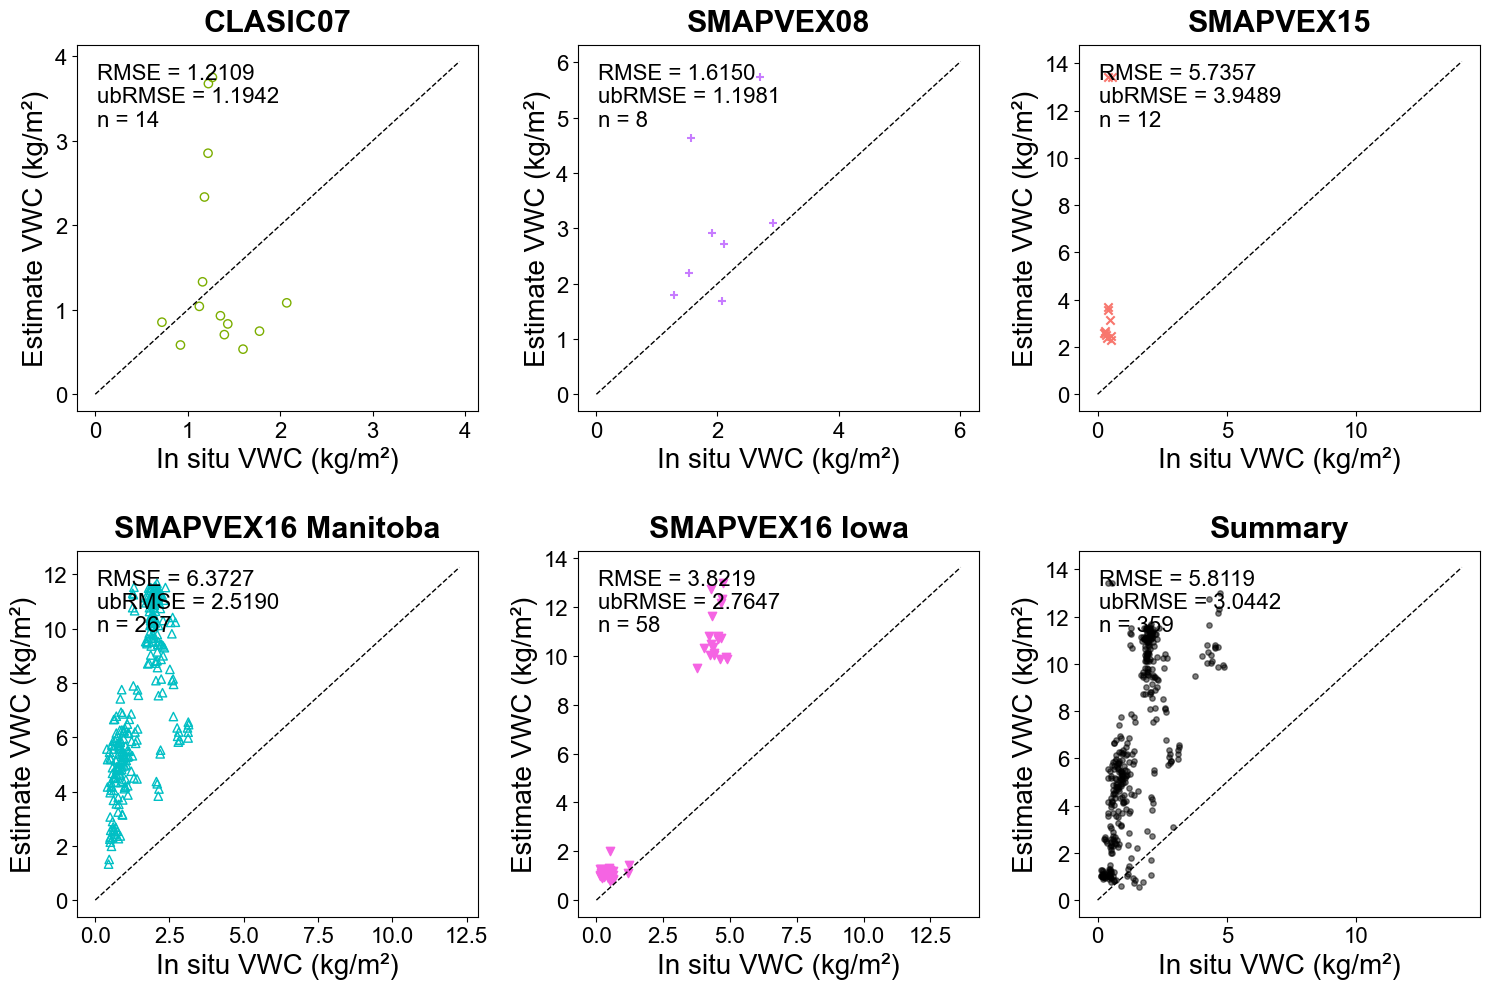

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

# 输入与输出路径
INPUT_FILE = r"G:\data\VWC\test-VWC\VWC Map Validation\VWC_Map_results_ML.xlsx"
OUTPUT_FILE = r"G:\data\VWC\VWCMap\T3C-VWC\Scatter_American.png"

# Sheet名称与样式（去掉 SMEX02）
SHEET_MAP = {
    "CLASIC07": {"marker": "o", "facecolor": "none", "edgecolor": "#7CAE00"},
    "SMAPVEX08": {"marker": "+", "color": "#C77CFF"},
    "SMAPVEX15": {"marker": "x", "color": "#F8766D"},
    "SMAPVEX16 Manitoba": {"marker": "^", "facecolor": "none", "edgecolor": "#00BFC4"},
    "SMAPVEX16 Iowa": {"marker": "v", "color": "#F564E3"},
}

# 计算指标函数
def calc_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    bias = np.mean(y_pred - y_true)
    ubrmse = np.sqrt(np.mean(((y_pred - y_true) - bias) ** 2))
    r2 = r2_score(y_true, y_pred)
    n = len(y_true)
    return rmse, ubrmse, r2, n

def main():
    plt.rcParams["font.family"] = "Arial"

    # 调整布局：共 6 个子图（去掉 SMEX02 后，右下角留给 Summary）
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()

    all_true, all_pred = [], []  # 用于汇总 Summary 数据
    idx = 0

    for sheet, style in SHEET_MAP.items():
        df = pd.read_excel(INPUT_FILE, sheet_name=sheet)
        df["T3C-VWC RF products"] = df["T3C-VWC RF products"].replace(-9999, np.nan)
        df = df.dropna(subset=["Map VWC", "T3C-VWC RF products"])
        df = df.drop_duplicates(subset=["LonC", "LatC", "Map VWC"], keep="first")

        if df.empty:
            print(f"⚠️ 跳过 {sheet}（无有效数据）")
            continue

        y_true = df["Map VWC"].values
        y_pred = df["T3C-VWC RF products"].values

        # 汇总保存
        all_true.extend(y_true)
        all_pred.extend(y_pred)

        rmse, ubrmse, r2, n = calc_metrics(y_true, y_pred)
        ax = axes[idx]
        idx += 1

        ax.scatter(y_true, y_pred, **style)

        max_val = max(np.max(y_true), np.max(y_pred)) * 1.05
        ax.plot([0, max_val], [0, max_val], "k--", lw=1)
        ax.set_xlabel("In situ VWC (kg/m²)", fontsize=20)
        ax.set_ylabel("Estimate VWC (kg/m²)", fontsize=20)
        ax.tick_params(axis='both', labelsize=16)
        ax.set_title(sheet, fontsize=22, fontweight="bold", pad=10)

        ax.text(
            0.05,
            0.95,
            f"RMSE = {rmse:.4f}\n"
            f"ubRMSE = {ubrmse:.4f}\n"
            f"n = {n}",
            transform=ax.transAxes,
            fontsize=16,
            verticalalignment="top",
        )

    # 绘制 Summary 子图
    summary_ax = axes[-1]
    if all_true and all_pred:
        all_true = np.array(all_true)
        all_pred = np.array(all_pred)
        rmse, ubrmse, r2, n = calc_metrics(all_true, all_pred)

        summary_ax.scatter(
            all_true, all_pred, s=15, color="black", alpha=0.5, label="All points"
        )
        max_val = max(np.max(all_true), np.max(all_pred)) * 1.05
        summary_ax.plot([0, max_val], [0, max_val], "k--", lw=1)
        summary_ax.set_xlabel("In situ VWC (kg/m²)", fontsize=20)
        summary_ax.set_ylabel("Estimate VWC (kg/m²)", fontsize=20)
        summary_ax.tick_params(axis='both', labelsize=16)
        summary_ax.set_title("Summary", fontsize=22, fontweight="bold", pad=10)
        summary_ax.text(
            0.05,
            0.95,
            f"RMSE = {rmse:.4f}\n"
            f"ubRMSE = {ubrmse:.4f}\n"
            f"n = {n}",
            transform=summary_ax.transAxes,
            fontsize=16,
            verticalalignment="top",
        )
    else:
        summary_ax.axis("off")
        summary_ax.text(0.5, 0.5, "No data", ha="center", va="center", fontsize=20)

    plt.tight_layout(h_pad=3.0)
    plt.savefig(OUTPUT_FILE, dpi=300, bbox_inches="tight")
    print(f"✅ 图像已保存至:\n{OUTPUT_FILE}")
    plt.show()

if __name__ == "__main__":
    main()


### （3） 将影像填充至图像中(填充草部分结果，因为采样都属于草)

In [6]:
# 先填充T3C-VWC的影像，使其满足验证数据
import os
import pandas as pd
import rasterio
from datetime import datetime

# 配置路径
excel_path = r"G:\data\VWC\test-VWC\VWC Map Validation\VWC_Map_results_ML.xlsx"
tif_folder = r"G:\data\VWC\VWCMap\T3C-VWC\Daily\Grass"

# 读取Excel文件
with pd.ExcelFile(excel_path) as xls:
    sheet_names = xls.sheet_names
    sheets_dict = {sheet: pd.read_excel(xls, sheet_name=sheet) for sheet in sheet_names}

# 处理每个sheet
for sheet_name, df in sheets_dict.items():
    # 添加新列
    df['T3C-VWC RF products(Grass)'] = None
    
    # 检查是否存在日期列
    if 'Date' not in df.columns and 'Datetime' not in df.columns:
        print(f"Sheet '{sheet_name}' 缺少日期列，跳过处理")
        continue
    
    # 确定日期列名
    date_col = 'Date' if 'Date' in df.columns else 'Datetime'
    
    # 转换日期为字符串格式YYYYMMDD
    df['date_str'] = df[date_col].apply(
        lambda x: x.strftime('%Y%m%d') if isinstance(x, datetime) else str(x).split()[0].replace('-', '')
    )
    
    # 分组处理相同日期的数据
    grouped = df.groupby('date_str')
    
    for date_str, group in grouped:
        tif_path = os.path.join(tif_folder, f"VWC-{date_str}.tif")
        
        # 检查TIFF文件是否存在
        if not os.path.exists(tif_path):
            print(f"文件不存在: {tif_path}")
            continue
        
        try:
            # 读取TIFF文件
            with rasterio.open(tif_path) as src:
                # 检查TIFF尺寸
                if src.height != 1800 or src.width != 3600:
                    print(f"警告: {tif_path} 尺寸不符 ({src.height}x{src.width})")
                
                # 提取数据
                for idx, row in group.iterrows():
                    try:
                        # 转换为整数索引（假设行列索引从1开始）
                        row_idx = int(row['row']) - 1
                        col_idx = int(row['col']) - 1
                        
                        # 验证索引范围
                        if 0 <= row_idx < 1800 and 0 <= col_idx < 3600:
                            # 读取像素值
                            value = src.read(1, window=((row_idx, row_idx+1), (col_idx, col_idx+1)))
                            df.at[idx, 'T3C-VWC RF products(Grass)'] = value[0, 0]
                    except (ValueError, KeyError) as e:
                        print(f"行列索引错误: {e}")
        except rasterio.RasterioIOError:
            print(f"无法读取文件: {tif_path}")
    
    # 删除临时列
    df.drop('date_str', axis=1, inplace=True)

# 保存更新后的Excel文件
with pd.ExcelWriter(excel_path, engine='openpyxl') as writer:
    for sheet_name, df in sheets_dict.items():
        df.to_excel(writer, sheet_name=sheet_name, index=False)

print("处理完成！")

处理完成！


### （4）  （3）中的填充结果进行散点图验证

✅ 图像已保存至:
G:\data\VWC\VWCMap\T3C-VWC\Scatter_American_GrassVal.png


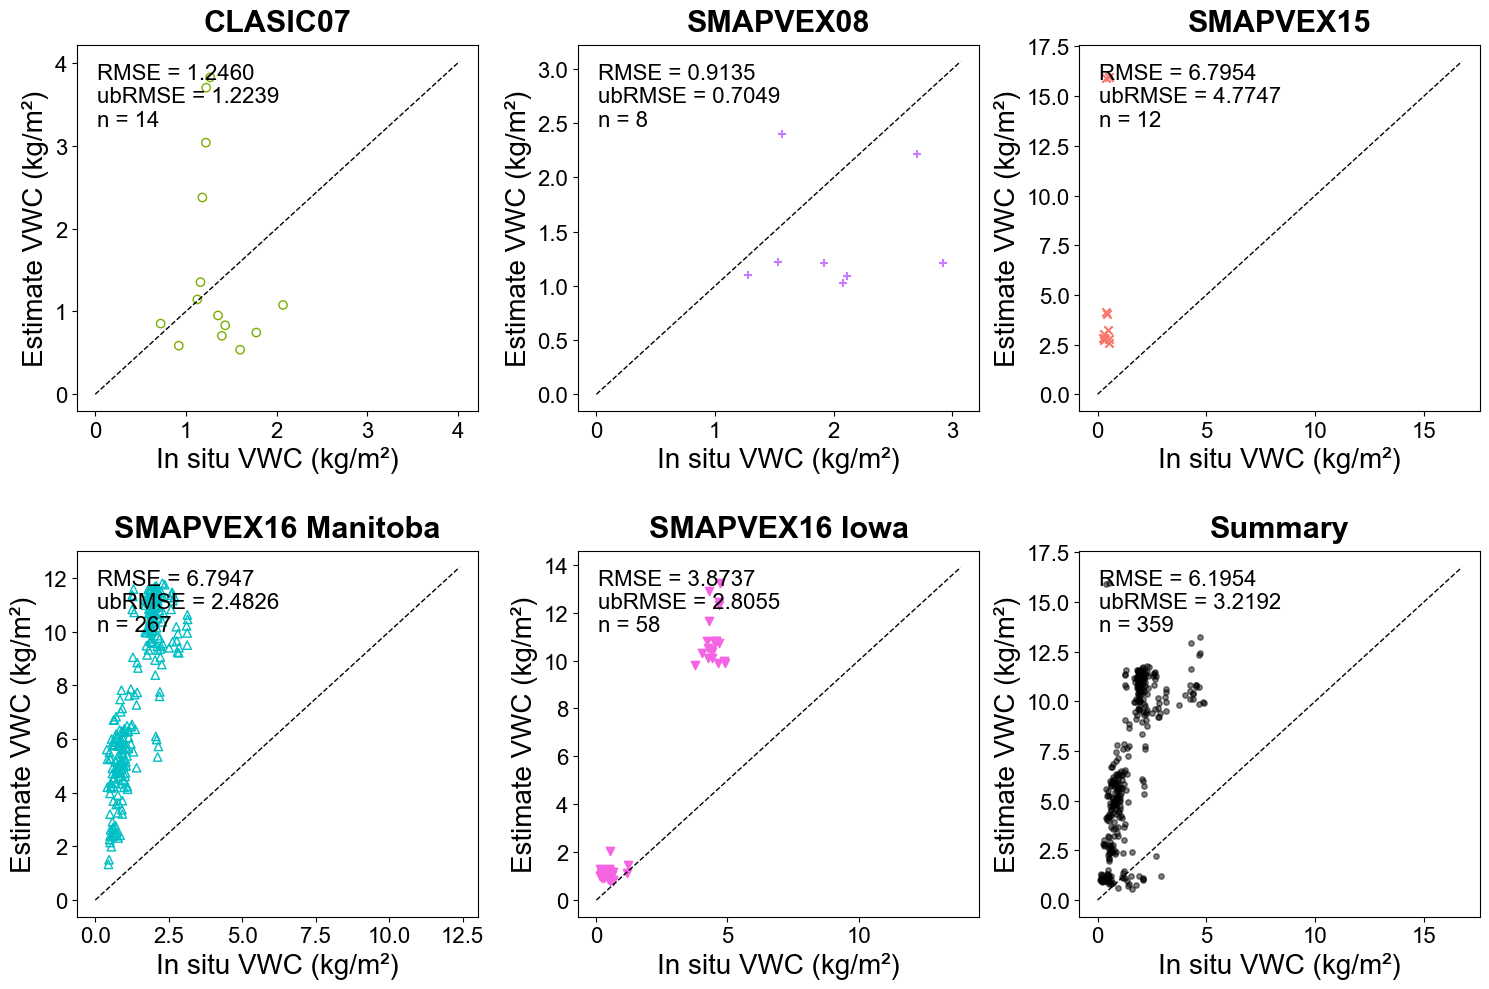

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

# 输入与输出路径
INPUT_FILE = r"G:\data\VWC\test-VWC\VWC Map Validation\VWC_Map_results_ML.xlsx"
OUTPUT_FILE = r"G:\data\VWC\VWCMap\T3C-VWC\Scatter_American_GrassVal.png"

# Sheet名称与样式（去掉 SMEX02）
SHEET_MAP = {
    "CLASIC07": {"marker": "o", "facecolor": "none", "edgecolor": "#7CAE00"},
    "SMAPVEX08": {"marker": "+", "color": "#C77CFF"},
    "SMAPVEX15": {"marker": "x", "color": "#F8766D"},
    "SMAPVEX16 Manitoba": {"marker": "^", "facecolor": "none", "edgecolor": "#00BFC4"},
    "SMAPVEX16 Iowa": {"marker": "v", "color": "#F564E3"},
}

# 计算指标函数
def calc_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    bias = np.mean(y_pred - y_true)
    ubrmse = np.sqrt(np.mean(((y_pred - y_true) - bias) ** 2))
    r2 = r2_score(y_true, y_pred)
    n = len(y_true)
    return rmse, ubrmse, r2, n

def main():
    plt.rcParams["font.family"] = "Arial"

    # 调整布局：共 6 个子图（去掉 SMEX02 后，右下角留给 Summary）
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()

    all_true, all_pred = [], []  # 用于汇总 Summary 数据
    idx = 0

    for sheet, style in SHEET_MAP.items():
        df = pd.read_excel(INPUT_FILE, sheet_name=sheet)
        df["T3C-VWC RF products(Grass)"] = df["T3C-VWC RF products(Grass)"].replace(-9999, np.nan)
        df = df.dropna(subset=["Map VWC", "T3C-VWC RF products(Grass)"])
        df = df.drop_duplicates(subset=["LonC", "LatC", "Map VWC"], keep="first")

        if df.empty:
            print(f"⚠️ 跳过 {sheet}（无有效数据）")
            continue

        y_true = df["Map VWC"].values
        y_pred = df["T3C-VWC RF products(Grass)"].values

        # 汇总保存
        all_true.extend(y_true)
        all_pred.extend(y_pred)

        rmse, ubrmse, r2, n = calc_metrics(y_true, y_pred)
        ax = axes[idx]
        idx += 1

        ax.scatter(y_true, y_pred, **style)

        max_val = max(np.max(y_true), np.max(y_pred)) * 1.05
        ax.plot([0, max_val], [0, max_val], "k--", lw=1)
        ax.set_xlabel("In situ VWC (kg/m²)", fontsize=20)
        ax.set_ylabel("Estimate VWC (kg/m²)", fontsize=20)
        ax.tick_params(axis='both', labelsize=16)
        ax.set_title(sheet, fontsize=22, fontweight="bold", pad=10)

        ax.text(
            0.05,
            0.95,
            f"RMSE = {rmse:.4f}\n"
            f"ubRMSE = {ubrmse:.4f}\n"
            f"n = {n}",
            transform=ax.transAxes,
            fontsize=16,
            verticalalignment="top",
        )

    # 绘制 Summary 子图
    summary_ax = axes[-1]
    if all_true and all_pred:
        all_true = np.array(all_true)
        all_pred = np.array(all_pred)
        rmse, ubrmse, r2, n = calc_metrics(all_true, all_pred)

        summary_ax.scatter(
            all_true, all_pred, s=15, color="black", alpha=0.5, label="All points"
        )
        max_val = max(np.max(all_true), np.max(all_pred)) * 1.05
        summary_ax.plot([0, max_val], [0, max_val], "k--", lw=1)
        summary_ax.set_xlabel("In situ VWC (kg/m²)", fontsize=20)
        summary_ax.set_ylabel("Estimate VWC (kg/m²)", fontsize=20)
        summary_ax.tick_params(axis='both', labelsize=16)
        summary_ax.set_title("Summary", fontsize=22, fontweight="bold", pad=10)
        summary_ax.text(
            0.05,
            0.95,
            f"RMSE = {rmse:.4f}\n"
            f"ubRMSE = {ubrmse:.4f}\n"
            f"n = {n}",
            transform=summary_ax.transAxes,
            fontsize=16,
            verticalalignment="top",
        )
    else:
        summary_ax.axis("off")
        summary_ax.text(0.5, 0.5, "No data", ha="center", va="center", fontsize=20)

    plt.tight_layout(h_pad=3.0)
    plt.savefig(OUTPUT_FILE, dpi=300, bbox_inches="tight")
    print(f"✅ 图像已保存至:\n{OUTPUT_FILE}")
    plt.show()

if __name__ == "__main__":
    main()
